In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ./drive/My Drive/vision_transformer/LocallyEnhancedConvTransformer

/content/drive/My Drive/vision_transformer/LocallyEnhancedConvTransformer


In [ ]:
!pip install timm

In [ ]:
import math
import time
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_


# device configuration
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 준비

In [ ]:

#cifar10
normalize = transforms.Normalize(
    mean = [0.4914, 0.4822, 0.4465],
    std = [0.2023, 0.1994, 0.2010],
)
"""
# cifar 100 normalize
normalize = transforms.Normalize(
    mean = [0.5071, 0.4867, 0.4408],
    std = [0.2675, 0.2565, 0.2761],
)
"""

train_transform = transforms.Compose([
                                transforms.RandomCrop(32, padding = 4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandAugment(),
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                normalize,
])
valid_transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                normalize,      
])
train_dataset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform= train_transform)
valid_dataset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = valid_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size = 64, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


# 모델 정의

In [ ]:
class ConvEmbedding(nn.Module):
    def __init__(self, 
                 patch_size = 7, 
                 stride = 4, 
                 in_chans = 3, 
                 embed_dim = 64):
        super().__init__()

        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        assert max(patch_size) > stride, "Set larger patch_size than stride"

        self.proj = nn.Conv2d(in_chans, embed_dim, 
                              kernel_size = patch_size, 
                              stride = stride,
                              padding = (patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape

        x = x.reshape(B, C, -1).transpose(-2, -1)
        x = self.norm(x)
        return x, H, W

In [ ]:
class LocallyEnhancedAttention(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads,
                 qkv_bias = False,
                 attn_drop = 0.,
                 proj_drop = 0.,
                 kernel_size = 3,
                 sr_ratio = 7,):
        super().__init__()

        self.num_heads = num_heads
        self.scale = dim ** -0.5
        self.attention_map = None

        self.proj_v = nn.Linear(dim, dim, bias = qkv_bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size = kernel_size, stride = 1, 
                      padding = kernel_size // 2, bias = qkv_bias, groups = dim),
            nn.BatchNorm2d(dim),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size = kernel_size, stride = 1, 
                      padding = kernel_size // 2, bias = qkv_bias, groups = dim),
            nn.BatchNorm2d(dim),
        )
        self.downsample_k = nn.AvgPool2d(kernel_size = sr_ratio)
        self.downsample_q = nn.AvgPool2d(kernel_size = sr_ratio)
        self.gelu = nn.GELU()


        # For upsampling attention map
        self.k_upsample = nn.Upsample(scale_factor = sr_ratio, mode = "bilinear")
        
        self.v_upsample = nn.Upsample(scale_factor = sr_ratio, mode = 'bilinear')
        self.v_conv = nn.Conv2d(dim, dim, kernel_size = kernel_size, stride = 1,
                                padding = kernel_size // 2, groups = dim, bias = False)
        self.v_bn = nn.BatchNorm2d(dim)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    
    def forward(self, x):
        B, N, C = x.shape
        h, w = int(math.sqrt(N)), int(math.sqrt(N))
     
        v = self.proj_v(x)
        skip = v
        skip = skip.reshape(B, h, w, C).permute(0, 3, 1, 2)
        skip = self.conv1(skip)
        q = self.downsample_q(skip)   # B x C x h' x w'
        skip = self.gelu(skip)
        skip = self.conv2(skip)
        k = self.downsample_k(skip)
        skip = self.gelu(skip)
        skip = skip.reshape(B, C, -1).transpose(-2, -1)

        q = q.reshape(B, self.num_heads, C // self.num_heads, -1).transpose(-2, -1)
        k = k.reshape(B, self.num_heads, C // self.num_heads, -1).transpose(-2, -1)
        v = v.reshape(B, N, self.num_heads, C // self.num_heads).transpose(1, 2)

        attn = (q @ k.transpose(-2, -1))   # B x num_heads x N_ x N_ (N_ = h' * w')

        # Upsample attention map
        N_ = attn.shape[-1]
        h_, w_ = int(math.sqrt(N_)), int(math.sqrt(N_))
        attn = attn.reshape(-1, N_, int(math.sqrt(N_)), int(math.sqrt(N_)))
        attn = self.k_upsample(attn) * self.scale
        attn = attn.reshape(B, self.num_heads, N_, N)

        attn = attn.softmax(dim = -1)
        self.attention_map = attn
        attn = self.attn_drop(attn)
        
        x = (attn @ v).reshape(B, self.num_heads, h_, w_, -1)
        x = x.permute(0, 1, 4, 2, 3).reshape(B, -1, h_, w_)
        x = self.v_bn(self.v_conv(self.v_upsample(x)))
        x = x.reshape(B, C, -1).transpose(-2, -1) + skip
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

In [ ]:
class LocallyEnhancedFeedForward(nn.Module):
    def __init__(self, 
                 in_features,
                 hidden_features = None,
                 out_features = None,
                 act_layer = nn.GELU,
                 drop = 0.,
                 kernel_size = 3,
                 with_bn = True):
        super().__init__()

        hidden_features = hidden_features or in_features
        out_features = out_features or in_features

        # Pointwise
        self.conv1 = nn.Conv2d(in_features, hidden_features, kernel_size = 1,
                               stride = 1, padding = 0)
        
        # Depthwise
        self.conv2 = nn.Conv2d(hidden_features, hidden_features, kernel_size = kernel_size,
                               stride = 1, padding = kernel_size // 2, groups = hidden_features)
        
        # Pointwise
        self.conv3 = nn.Conv2d(hidden_features, out_features, kernel_size = 1,
                               stride = 1, padding = 0)
        
        self.act =  act_layer()
        self.drop = nn.Dropout(drop)
        self.with_bn = with_bn
        if with_bn:
            self.bn1 = nn.BatchNorm2d(hidden_features)
            self.bn2 = nn.BatchNorm2d(hidden_features)
            self.bn3 = nn.BatchNorm2d(out_features)
    
    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, int(math.sqrt(N)), int(math.sqrt(N)), C).permute(0, 3, 1, 2)
        if self.with_bn:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.act(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.act(x)
            x = self.drop(x)
            x = self.conv3(x)
            x = self.bn3(x)
        else:
            x = self.conv1(x)
            x = self.act(x)
            x = self.conv2(x)
            x = self.act(x)
            x = self.drop(x)
            x = self.conv3(x)
            
        x = self.drop(x)
        x = x.flatten(2).permute(0, 2, 1)
        return x

In [ ]:
class Block(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads,
                 mlp_ratio = 4,
                 qkv_bias = False,
                 drop = 0.,
                 attn_drop = 0.,
                 drop_path = 0.,
                 act_layer = nn.GELU,
                 norm_layer = nn.LayerNorm,
                 sr_ratio = 7.,
                 kernel_size = 3,
                 with_bn = True):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.leatt = LocallyEnhancedAttention(dim, num_heads, qkv_bias = qkv_bias, attn_drop = attn_drop,
                                              proj_drop = drop, kernel_size = kernel_size, sr_ratio = sr_ratio)
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.leff = LocallyEnhancedFeedForward(in_features = dim, hidden_features = dim * mlp_ratio,
                                               act_layer = act_layer, drop = drop, 
                                               kernel_size = kernel_size, with_bn = with_bn)
    
    def forward(self, x):
        x = x + self.drop_path(self.leatt(self.norm1(x)))
        x = x + self.drop_path(self.leff(self.norm2(x)))
        return x

In [ ]:
class LocallyEnhancedConvTransformer(nn.Module):
    def __init__(self, 
                 img_size = 224, 
                 patch_size = 7,
                 in_chans = 3,
                 kernel_size = 3,
                 num_classes = 100,
                 embed_dims = [64, 128, 192],
                 num_heads = [2, 4, 6],
                 mlp_ratios = [2, 3, 4],
                 qkv_bias = False,
                 drop_rate = 0.1,
                 attn_drop_rate = 0.,
                 drop_path_rate = 0.1,
                 depths = [1, 3, 1],
                 num_stages = 3,
                 act_layer = nn.GELU,
                 norm_layer = partial(nn.LayerNorm, eps = 1e-6),
                 with_bn = True):
        super().__init__()

        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]   # Stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = ConvEmbedding(patch_size = patch_size if i == 0 else 3,
                                        stride = 4 if i == 0 else 2,
                                        in_chans = 3 if i == 0 else embed_dims[i - 1],
                                        embed_dim = embed_dims[i])
            blocks = nn.ModuleList([
                                    Block(embed_dims[i], num_heads = num_heads[i],
                                          mlp_ratio = mlp_ratios[i], qkv_bias = qkv_bias,
                                          drop = drop_rate, attn_drop = attn_drop_rate,
                                          drop_path = dpr[cur + j], act_layer = act_layer,
                                          norm_layer = norm_layer, sr_ratio = 14 if i == 0 else 7,
                                          kernel_size = kernel_size, with_bn = with_bn) for j in range(depths[i])
            ])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"blocks{i + 1}", blocks)
            setattr(self, f"norm{i + 1}", norm)
        
        # Classifier Head
        self.head = nn.Linear(embed_dims[-1], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std = .02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def get_classifier(self):
        return self.head
    
    def reset_classifier(self, num_classes, global_pool = ''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0. else nn.Identity()
    
    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            blocks = getattr(self, f"blocks{i + 1}")
            norm = getattr(self, f"norm{i + 1}")

            x, H, W = patch_embed(x)
            for block in blocks:
                x = block(x)
            x = norm(x)

            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        return x.mean(dim = 1)
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [ ]:
model = LocallyEnhancedConvTransformer(num_classes = 100).to(device)


loss_history = {'train' : [], 'val' : []}
acc_history = {'train' : [], 'val' : []}

In [ ]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

In [ ]:
print(count_parameters(model))

1.168932


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def test():
    input = torch.rand(50, 3, 224, 224).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input)
    print(outputs.size())
    model.train()
    
start_time = time.time()
for _ in range(50):
    test()
end_time = time.time()

print(end_time - start_time)
print(2500 / (end_time - start_time))

torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size([50, 100])
torch.Size

13.55935025215149


184.37461629869173

# 학습하기

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.05)

from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(optimizer,T_max = 60)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def loss_acc_batch(output, target, max_norm = 5, train = True):
    loss_batch = criterion(output, target)
    _, predicted = torch.max(output, dim = -1)
    correct_batch = (predicted == target).sum().item()

    # Train the model
    if train:
        optimizer.zero_grad()
        loss_batch.backward()
        if max_norm is not None:
            nn.utils.clip_grad_norm(model.parameters(), max_norm)
        optimizer.step()

    return loss_batch.item(), correct_batch

In [ ]:
params_train = {
    'num_epochs':60,
    'max_norm': 5,
    'optimizer':optimizer,
    'criterion': criterion,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'filename': 'CIFAR10_LeCTv2_60_epochs.pth.tar',
}

In [ ]:
def train_fn(model, params):
    num_epochs = params['num_epochs']
    max_norm = params['max_norm']
    criterion = params['criterion']
    optimizer = params['optimizer']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    filename = params['filename']

    best_loss = float('inf')
    best_model_checkpoint = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        curr_lr = get_lr(optimizer)
        print("Epoch {} / {}, current lr = {}".format(epoch + 1, num_epochs, curr_lr))

        model.train()


        train_loss = 0.
        train_correct = 0.
        total = len(train_dataset)

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss_batch, correct_batch = loss_acc_batch(outputs, labels, max_norm)

            train_loss += loss_batch
            train_correct += correct_batch

            if sanity_check is True:
                break
        lr_scheduler.step()
        
        train_loss = train_loss / total
        train_acc = train_correct / total

        loss_history['train'].append(train_loss)
        acc_history['train'].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            total = len(valid_dataset)

            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss_batch, correct_batch = loss_acc_batch(outputs, labels, train = False)

                val_loss += loss_batch
                val_correct += correct_batch

                if sanity_check is True:
                    break
            
            val_loss = val_loss / total
            val_acc = val_correct / total

        loss_history['val'].append(val_loss)
        acc_history['val'].append(val_acc)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_checkpoint = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), filename)
            print("copied best model weights!")
        
        
        print('train loss : %.6f, val loss : %.6f, accuracy : %.2f, time %.4f min' %
              (train_loss, val_loss, 100 * val_acc, (time.time() - start_time) / 60))
        print("-" * 10)
    
    model.load_state_dict(best_model_checkpoint)
    return model, loss_history, acc_history

In [ ]:
model, loss_history, acc_history = train_fn(model, params_train)

Epoch 1 / 60, current lr = 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


copied best model weights!
train loss : 0.026101, val loss : 0.021259, accuracy : 49.89, time 15.8757 min
----------
Epoch 2 / 60, current lr = 0.0009993147673772868
copied best model weights!
train loss : 0.018436, val loss : 0.018478, accuracy : 59.29, time 31.7144 min
----------
Epoch 3 / 60, current lr = 0.0009972609476841365
copied best model weights!
train loss : 0.015265, val loss : 0.014238, accuracy : 69.01, time 47.5386 min
----------
Epoch 4 / 60, current lr = 0.0009938441702975688
copied best model weights!
train loss : 0.013305, val loss : 0.010486, accuracy : 77.09, time 63.3451 min
----------
Epoch 5 / 60, current lr = 0.0009890738003669028
train loss : 0.011852, val loss : 0.011022, accuracy : 75.58, time 79.1685 min
----------
Epoch 6 / 60, current lr = 0.0009829629131445341
copied best model weights!
train loss : 0.010838, val loss : 0.010398, accuracy : 77.58, time 95.0161 min
----------
Epoch 7 / 60, current lr = 0.0009755282581475769
copied best model weights!
trai

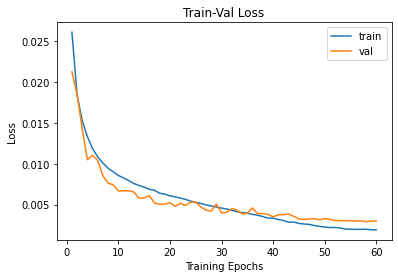

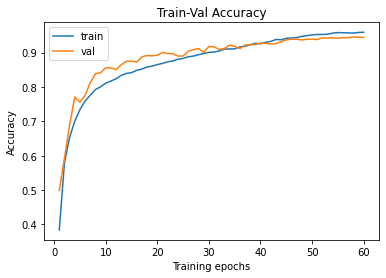

In [ ]:
import matplotlib.pyplot as plt
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs + 1), loss_history['train'], label = 'train')
plt.plot(range(1, num_epochs + 1), loss_history['val'], label = 'val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs + 1), acc_history['train'], label = 'train')
plt.plot(range(1, num_epochs + 1), acc_history['val'], label = 'val')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import json

with open('CIFAR10_LeCTv2_loss_history.json', 'w') as f:
    json.dump(loss_history, f, indent = 4)

with open('CIFAR10_LeCTv2_acc_history.json', 'w') as g:
    json.dump(acc_history, g, indent = 4)